# Playlist SVM

Given a list of playlists, can unknown tracks be correctly classified?

In [5]:
playlist_names = ["RAP", "EDM", "ROCK", "METAL", "JAZZ", "POP"] # super-genres
playlist_names = ["ALL RAP", "EDM", "ROCK", "METAL", "JAZZ", "POP"] # super-genres
# playlist_names = ["RAP", "EDM", "ROCK", "METAL", "JAZZ"] # super-genres without POP
# playlist_names = ["DNB", "HOUSE", "TECHNO", "GARAGE", "DUBSTEP", "BASS"] # EDM playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap"] # rap decades
# playlist_names = ["UK RAP", "US RAP"] # UK/US split
# playlist_names = ["uk rap", "grime", "drill", "afro bash"] # british rap playlists
# playlist_names = ["20s rap", "10s rap", "00s rap", "90s rap", "80s rap", "trap", "gangsta rap", "industrial rap", "weird rap", "jazz rap", "boom bap", "trap metal"] # american rap playlists
# playlist_names = ["rock", "indie", "punk", "pop rock", "bluesy rock", "hard rock", "chilled rock", "emo", "pop punk", "stoner rock/metal", "post-hardcore", "melodic hardcore", "art rock", "post-rock", "classic pop punk", "90s rock & grunge", "90s indie & britpop", "psych"] # rock playlists
# playlist_names = ["metal", "metalcore", "mathcore", "hardcore", "black metal", "death metal", "doom metal", "sludge metal", "classic metal", "industrial", "nu metal", "calm metal", "thrash metal"] # metal playlists

# headers = float_headers + ["duration_ms", "mode", "loudness", "tempo"]
headers = float_headers

Pull and process playlist information.

1. Get live playlist track information from spotify
2. Filter listening history for these tracks

Filter out tracks without features and drop duplicates before taking only the descriptor parameters

In [6]:
playlists = [get_playlist(i, spotnet) for i in playlist_names] # 1)

# filter playlists by join with playlist track/artist names
filtered_playlists = [pd.merge(track_frame(i.tracks), scrobbles, on=['track', 'artist']) for i in playlists] # 2)

filtered_playlists = [i[pd.notnull(i["uri"])] for i in filtered_playlists]
# distinct on uri
filtered_playlists = [i.drop_duplicates(['uri']) for i in filtered_playlists]
# select only descriptor float columns
filtered_playlists = [i.loc[:, headers] for i in filtered_playlists]

Construct the dataset with associated labels before splitting into a train and test set.

In [7]:
dataset = pd.concat(filtered_playlists)
labels = [np.full(len(plst), idx) for idx, plst in enumerate(filtered_playlists)]
labels = np.concatenate(labels)

# stratify: maintains class proportions in test and train set
data_train, data_test, labels_train, labels_test = train_test_split(dataset, labels, test_size=0.25, random_state=70, stratify=labels)

# SVM Kernels
Support Vector Machine

In [12]:
### TRAIN ###
clf = svm.SVC(kernel='rbf')
clf.fit(data_train, labels_train)

wclf = svm.SVC(kernel='rbf', gamma = 1/(2*(sig_max**2)), C=c_max, class_weight='balanced') # weight classes based on prevalence
wclf.fit(data_train, labels_train)

lclf = svm.SVC(kernel='linear', class_weight='balanced')
lclf.fit(data_train, labels_train)

pclf = svm.SVC(kernel='poly', degree=3, class_weight='balanced')
pclf.fit(data_train, labels_train)

sclf = svm.SVC(kernel='sigmoid', class_weight='balanced')
sclf.fit(data_train, labels_train)

### EVALUATE ###
models = {'uw-rbf': clf, 'w-rbf': wclf, 'linear': lclf, 'poly': pclf, 'sigmoid': sclf}
accuracy = {i: j.score(data_test, labels_test) for i, j in models.items()}

(pd.DataFrame(accuracy, index=['accuracy %']) * 100).round(decimals=2)

,uw-rbf,w-rbf,linear,poly,sigmoid
accuracy %,75.19,72.42,68.26,71.54,32.49


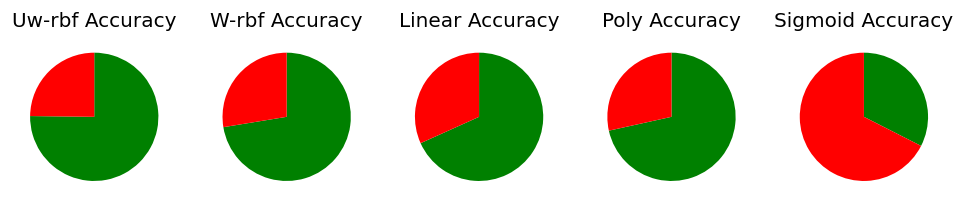

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=len(models))
fig.set_figwidth(2 * len(models))
fig.set_figheight(2)

for (name, acc), ax in zip(accuracy.items(), ax):
    ax.pie([acc, 1 - acc], colors=['g', 'r'], startangle=90, counterclock=False)
    ax.set_title(f"{name.capitalize()} Accuracy")

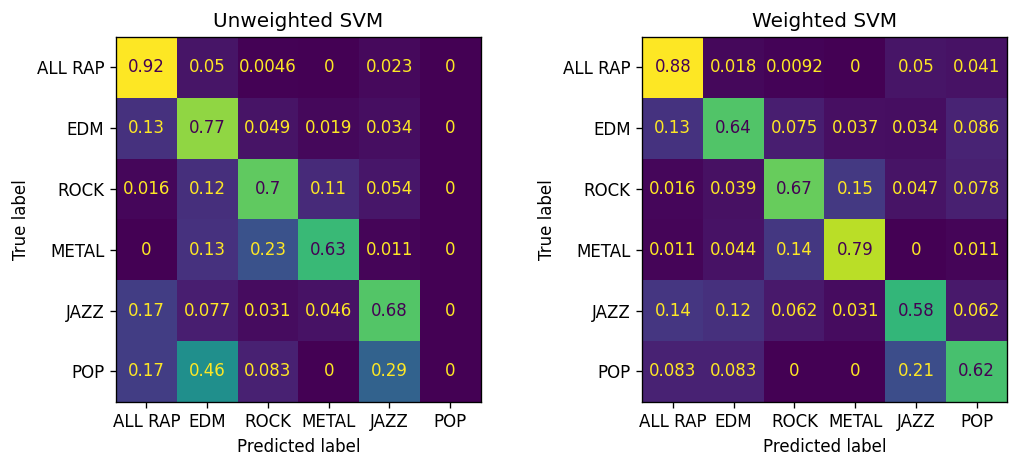

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(9)
# fig.set_figheight(15)

args = {
    'normalize': 'true',
    'colorbar': False,
    'display_labels': playlist_names
}

plot_confusion_matrix(clf, data_test, labels_test, ax=ax[0], **args)
ax[0].set_title('Unweighted SVM')

plot_confusion_matrix(wclf, data_test, labels_test, ax=ax[1], **args)
ax[1].set_title('Weighted SVM')

fig.tight_layout()

## Unweighted Classes

From the above unweighted scenario, it is clear that the Pop playlists was not effective for classifying similar tracks. This is likely primarily due to the larger size of the Rap (\~800), EDM (\~1,300) and Rock (\~700) playlists compared to Pop (\~125). Additionally, there is overlap with other genres such as Rap and EDM where much of the confusion occured. Also not helping is that one of the sub-playlists is shared across EDM and Pop, electropop. as EDM is already such a larger playlist it is unsurpising that this performance was poor. The overlap with Rock is understandable as Pop contains an Indie Pop sub-playlist which could have cause some confusion. Quite surprising was the confusion for Jazz as I wouldn't have thought there would be much overlap here.

The other major confusion was with Rock and Metal, specifically classing Metal tracks as Rock. This could be expected due to the similarity in tone.

## Weighted Classes

When weighting the classes by prevalence in the dateset, the model is generally better at classification. The clearest difference is the ability to classify Pop songs. Without weighting, no songs were correctly classified as Pop but were instead mis-identified as Rap, EDM, Rock and Jazz. When re-weighting, the Pop playlist was now correctly classified almost 60% of the time. Mis-identification as Rap, EDM and Rock dropped from a combined 85% to just 20%. Interestingly, the mis-classification of Pop as Jazz increased from 15% to 21%.

The improved accuracy of the Pop model reduced the accuracy of some others. The accuracy of Rap, EDM and Rock decreased as some tracks were instead classified as Pop. EDM and Rock were worse affected than Rap with around 15% Pop error rate compared to Rap's 9%. As discussed previously, this could be due to the overlap in aural tone. The overall of Rap was not significantly affected by this Pop error rate as, to compensate, the EDM error rate dropped from 12% to just 3%.

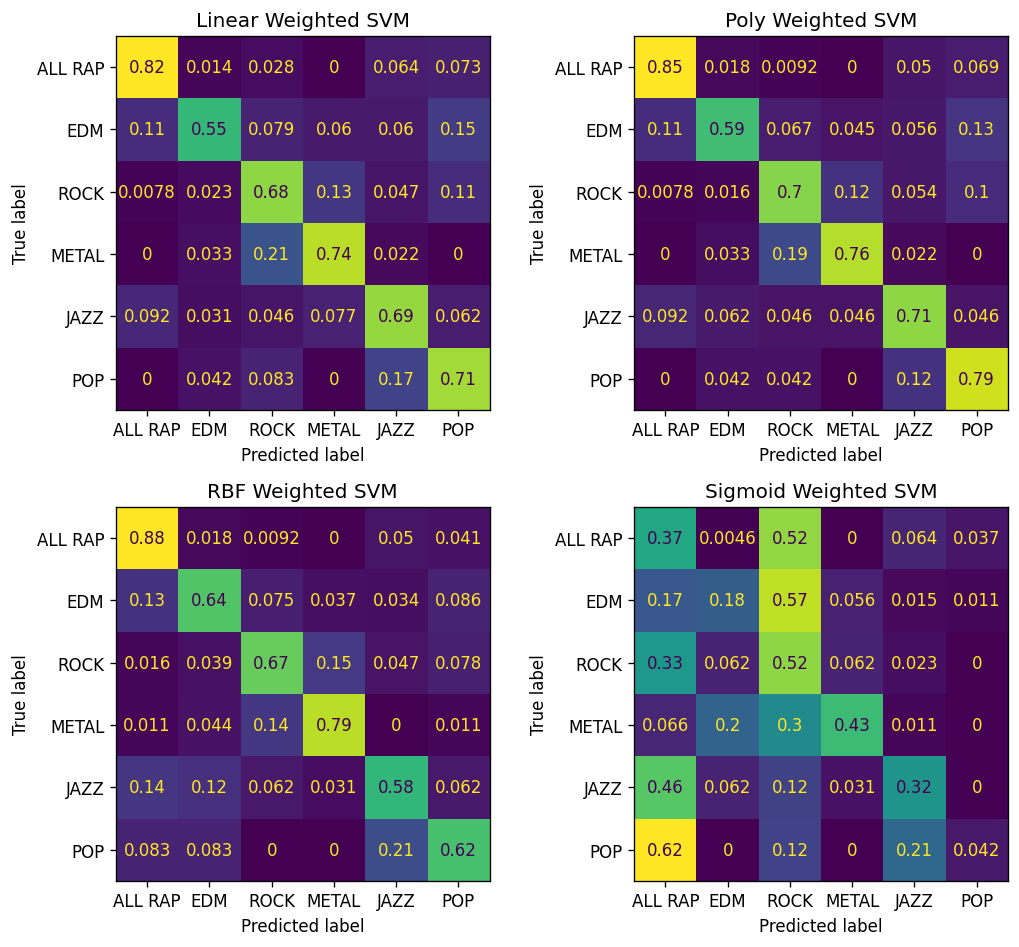

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(9)
fig.set_figheight(8)

plot_confusion_matrix(lclf, data_test, labels_test, ax=ax[0][0], **args)
ax[0][0].set_title('Linear Weighted SVM')

plot_confusion_matrix(pclf, data_test, labels_test, ax=ax[0][1], **args)
ax[0][1].set_title('Poly Weighted SVM')

plot_confusion_matrix(wclf, data_test, labels_test, ax=ax[1][0], **args)
ax[1][0].set_title('RBF Weighted SVM')

plot_confusion_matrix(sclf, data_test, labels_test, ax=ax[1][1], **args)
ax[1][1].set_title('Sigmoid Weighted SVM')

fig.tight_layout()

## Other Tests

Take a handful of other tracks which I don't listen to and aren't in any playlists to see if they can also be classified

In [16]:
### PREPARE ###
test_uris = ["spotify:track:53yqxU2EKKzbuQZEUEVtxc",
             "spotify:track:5W7xC99N2Zzfh69r7I7zWK",
             "spotify:track:38R2EViAkYOFG8ZkG3GLtW",
             "spotify:track:6T6D9CIrHkALcHPafDFA6L",
             "spotify:track:0sfdiwck2xr4PteGOdyOfz",
             "spotify:track:1BrgjqSg9du0lj3TUMLluL",
             "spotify:track:5nCnSnLtotQ8eB4E189U91",
             "spotify:track:3GOZbK2epuHzCt5YvvVFHO",
             "spotify:track:3cjF2OFRmip8spwZYQRKxP",
             "spotify:track:1COvXs6jaykXC73h9OSBVM"]
# inferring what playlists these would go in
test_labels = ["ROCK", "RAP", "JAZZ", "POP", "ROCK", "METAL", "METAL", "JAZZ", "RAP", "POP"] 

test_tracks = spotnet.tracks(uris=test_uris)
spotnet.populate_track_audio_features(tracks=test_tracks)

test_features = [   {j: k for j, k in i.audio_features.to_dict().items() 
                    if j in headers} 
                for i in test_tracks] # filter down to descriptor columns

### PREDICT ###
predictable_frame = pd.DataFrame(test_features)

predicted_labels = clf.predict(predictable_frame)
# predicted_labels = wclf.predict(predictable_frame)
labels_correct = [i == playlist_names[predicted_labels[idx]] for idx, i in enumerate(test_labels)]

### EVALUATE ###
for track, label, correct in zip(test_tracks, predicted_labels, labels_correct):
    print(f'{track.name} ({track.artists[0].name}) could be {playlist_names[label]} {"✓" if correct else "✗"}')

correct = sum(labels_correct) / len(labels_correct)
print(f'\n{correct*100:.2f}% Accurate')

Top Of The World (Five Finger Death Punch) could be ROCK ✓
Aston Martin Music (Rick Ross) could be ALL RAP ✗
On The Sunny Side Of The Street (Dizzy Gillespie) could be JAZZ ✓
Vibez (ZAYN) could be ALL RAP ✗
Shot In The Dark (AC/DC) could be ROCK ✓
To Hell and Back (Sabaton) could be ROCK ✗
Withstand The Fall Of Time (Immortal) could be METAL ✓
Alone Together - Rudy Van Gelder Remaster (Kenny Dorham) could be JAZZ ✓
Feel No Ways (Drake) could be ALL RAP ✗
BO$$ (Fifth Harmony) could be EDM ✗

50.00% Accurate


# SVM Cross-Validation

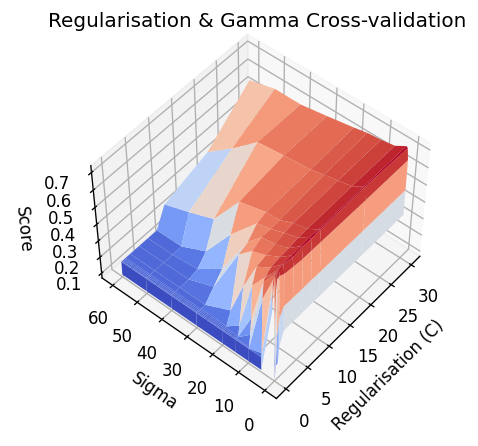

(0.5, 20)

In [11]:
# %matplotlib widget

sigma = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20, 30, 40, 50, 60] # for gamma paramater, for non-linear hyperplanes. Higher gammas (lower sigmas)
C = [0.01, 0.03, 0.1, 0.25, 0.5, 0.75, 1, 2, 4, 6, 8, 10, 20, 30] # for C. Penalty for error term. Balances smooth decision boundary with correctly classifying points (wiggle)
# sigma = [0.01, 0.03]
# C = [0.01, 0.03, 2]

scores = np.zeros((len(sigma), len(C)))
param_pairs = list()

for x, s in enumerate(sigma):
    for y, c in enumerate(C):
        clf = svm.SVC(kernel='rbf', gamma = 1/(2*(s**2)), C=c, class_weight='balanced')
        clf.fit(data_train, labels_train)
        scores[x, y] = clf.score(data_test, labels_test)
        param_pairs.append((s, c))
#         print(scores[x, y], s, c)
        
# print(scores)
        
index = np.argmax(scores)
sig_max, c_max = param_pairs[index]

X, Y = np.meshgrid(C, sigma)

fig = plt.figure()
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, scores, cmap=mpl.cm.coolwarm)
ax.set_title('Regularisation & Gamma Cross-validation')
# ax.set_xscale('log')
ax.set_xlabel('Regularisation (C)')
ax.set_ylabel('Sigma')
ax.set_zlabel('Score')
ax.view_init(50, -140)

# fig.colorbar(surf, shrink=0.3, aspect=6)
plt.show()
sig_max, c_max

# Imports & Setup

In [2]:
from datetime import datetime

from google.cloud import bigquery
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

from analysis.net import get_spotnet, get_playlist, track_frame
from analysis.query import *
from analysis import spotify_descriptor_headers, float_headers, days_since

import numpy as np
import pandas as pd

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

client = bigquery.Client()
spotnet = get_spotnet()
cache = 'query.csv'
first_day = datetime(year=2017, month=11, day=3)
sig_max, c_max = 0.5, 20

## Read Scrobble Frame

In [3]:
scrobbles = get_query(cache=cache)

## Write Scrobble Frame

In [6]:
scrobbles.reset_index().to_csv(cache, sep='\t')